In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
#import minopy.minopy_utilities as mnp
from minopy.lib.utils import est_corr_py
import minopy.simulation as mnp
from skimage.measure import label
import pandas as pd
from scipy import linalg as LA
from minopy.lib.utils import sequential_phase_linking_py, phase_linking_process_py, datum_connect_py


In [3]:
lamda = 56.0 #wavelength (mm)
n_img = 100
n_shp = 300
velocity = 4 #mm/y
velocity_fading = 50 #mm/y
tmp_bl = 6 #days

vel_phase = velocity/365*4*np.pi/lamda    #0.0024 # rad/day
decorr_days = 50

vel_fading = velocity_fading/365*4*np.pi/lamda  # 0.031 # rad/day
decorr_days_fading = 11

gamma0 = 0.6
gammaf_decor = 0
gammaf_cor = 0.2
gamma_fading = 0.18


In [4]:
def custom_cmap(vmin=0, vmax=1):
    """ create a custom colormap based on visible portion of electromagnetive wave."""

    from minopy.spectrumRGB import rgb
    rgb = rgb()
    import matplotlib as mpl
    cmap = mpl.colors.ListedColormap(rgb)
    norm = mpl.colors.Normalize(vmin, vmax)

    return cmap, norm

In [8]:
## seasonal
temp_baseline = np.ogrid[0:(tmp_bl * n_img):tmp_bl]

coh_sim_S_s = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_decor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=True)
coh_sim_L_s = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_cor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=True)


CCGsam_Sterm_s = mnp.simulate_neighborhood_stack(coh_sim_S_s, neighborSamples=n_shp)
CCGsam_Lterm_s = mnp.simulate_neighborhood_stack(coh_sim_L_s, neighborSamples=n_shp)

coh_est_S_s = np.array(est_corr_py(CCGsam_Sterm_s))
coh_est_L_s = np.array(est_corr_py(CCGsam_Lterm_s))

cov_S_s = mnp.CRLB_cov(coh_sim_S_s, n_shp)
cov_L_s = mnp.CRLB_cov(coh_sim_L_s, n_shp)

crl_S_s = np.hstack([0, np.sqrt(np.diag(cov_S_s))])
crl_L_s = np.hstack([0, np.sqrt(np.diag(cov_L_s))])

## no seasonal

coh_sim_S = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_decor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=False)
coh_sim_L = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_cor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=False)

CCGsam_Sterm = mnp.simulate_neighborhood_stack(coh_sim_S, neighborSamples=n_shp)
CCGsam_Lterm = mnp.simulate_neighborhood_stack(coh_sim_L, neighborSamples=n_shp)

coh_est_S = np.array(est_corr_py(CCGsam_Sterm))
coh_est_L = np.array(est_corr_py(CCGsam_Lterm))


cov_S = mnp.CRLB_cov(coh_sim_S, n_shp)
cov_L = mnp.CRLB_cov(coh_sim_L, n_shp)
crl_S = np.hstack([0,np.sqrt(np.diag(cov_S))])
crl_L = np.hstack([0,np.sqrt(np.diag(cov_L))])



Text(0.5, 1.0, 'Long term coherent (sequential)')

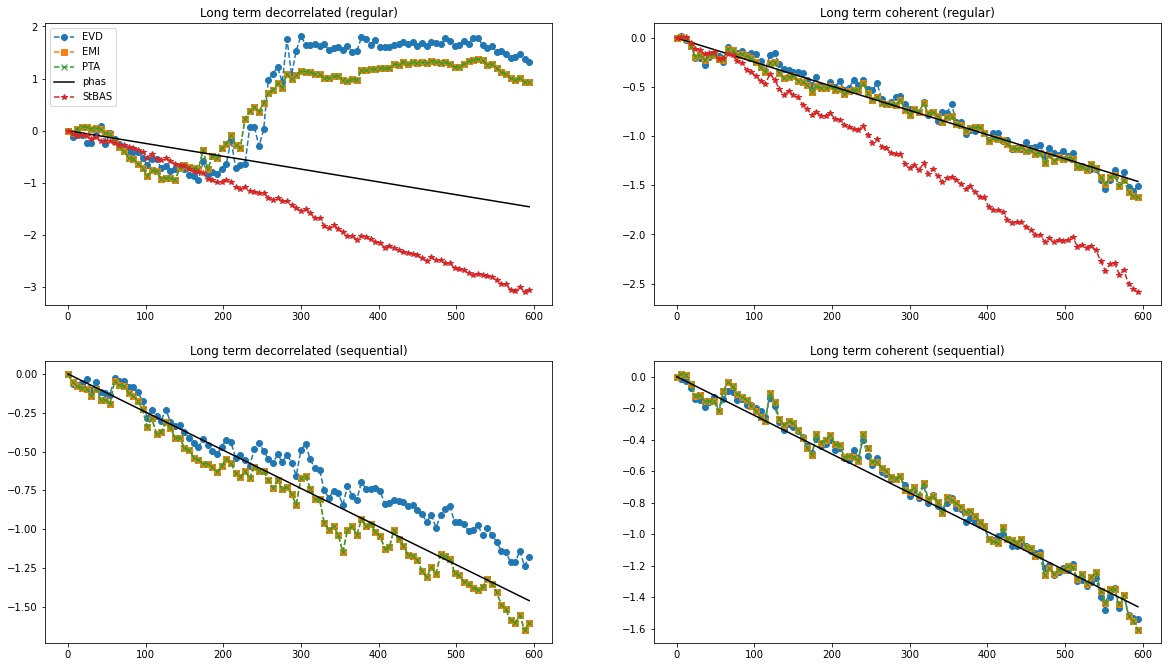

In [9]:
# running different methods for one realization   (No seasonality)

phas = -vel_phase * temp_baseline

ph_stbas, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm, 0, b'StBAS', False, 4)
ph_stbas_short = np.angle(np.array(ph_stbas)).reshape(-1, 1) 

ph_stbas, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm, 0, b'StBAS', False, 4)
ph_stbas_long = np.angle(np.array(ph_stbas)).reshape(-1, 1) 


####  Phase linking for long term decorrelated and long term coherent signal

### EVD
ph_EVD, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm, 0, b'EVD', False, 0)
ph_EVD_short = np.angle(np.array(ph_EVD)).reshape(-1, 1)
        
ph_EVD, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm, 0, b'EVD', False, 0)
ph_EVD_long = np.angle(np.array(ph_EVD)).reshape(-1, 1)


#### EMI
ph_EMI, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm, 0, b'EMI', False, 0)
ph_EMI_short = np.angle(np.array(ph_EMI)).reshape(-1, 1) 

ph_EMI, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm, 0, b'EMI', False, 0)
ph_EMI_long = np.angle(np.array(ph_EMI)).reshape(-1, 1) 

#### PTA
ph_PTA, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm, 0, b'PTA', False, 0)
ph_PTA_short = np.angle(np.array(ph_PTA)).reshape(-1, 1) 

ph_PTA, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm, 0, b'PTA', False, 0)
ph_PTA_long = np.angle(np.array(ph_PTA)).reshape(-1, 1) 

#### Sequential EVD

num_seq = np.int(n_img // 10)
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm, b'EVD', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EVD_short = np.angle(np.array(ph_vec)).reshape(-1, 1) 

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm, b'EVD', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EVD_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 

#### Sequential EMI
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm, b'EMI', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EMI_short = np.angle(np.array(ph_vec)).reshape(-1, 1) 

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm, b'EMI', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EMI_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 


#### Sequential PTA
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm, b'PTA', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_PTA_short = np.angle(np.array(ph_vec)).reshape(-1, 1)

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm, b'PTA', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_PTA_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 




## plotting

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,11.4))

ax = axs[0,0]
ax.plot(temp_baseline, ph_EVD_short, 'o--')
ax.plot(temp_baseline, ph_EMI_short, 's--')
ax.plot(temp_baseline, ph_PTA_short, 'x--')
ax.plot(temp_baseline, phas,'k-')
ax.plot(temp_baseline, ph_stbas_short, '*--')
ax.legend(('EVD', 'EMI', 'PTA', 'phas', 'StBAS'))
ax.set_title('Long term decorrelated (regular)')

ax = axs[0,1]
ax.plot(temp_baseline, ph_EVD_long, 'o--')
ax.plot(temp_baseline, ph_EMI_long, 's--')
ax.plot(temp_baseline, ph_PTA_long, 'x--')
ax.plot(temp_baseline, phas,'k-')
ax.plot(temp_baseline, ph_stbas_long, '*--')
ax.set_title('Long term coherent (regular)')



ax = axs[1,0]
ax.plot(temp_baseline, ph_vec_EVD_short, 'o--')
ax.plot(temp_baseline, ph_vec_EMI_short, 's--')
ax.plot(temp_baseline, ph_vec_PTA_short, 'x--')
ax.plot(temp_baseline, phas,'k-')
ax.set_title('Long term decorrelated (sequential)')


ax = axs[1,1]
ax.plot(temp_baseline, ph_vec_EVD_long, 'o--')
ax.plot(temp_baseline, ph_vec_EMI_long, 's--')
ax.plot(temp_baseline, ph_vec_PTA_long, 'x--')
ax.plot(temp_baseline, phas,'k-')
ax.set_title('Long term coherent (sequential)')



Text(0.5, 1.0, 'Long term coherent (sequential)')

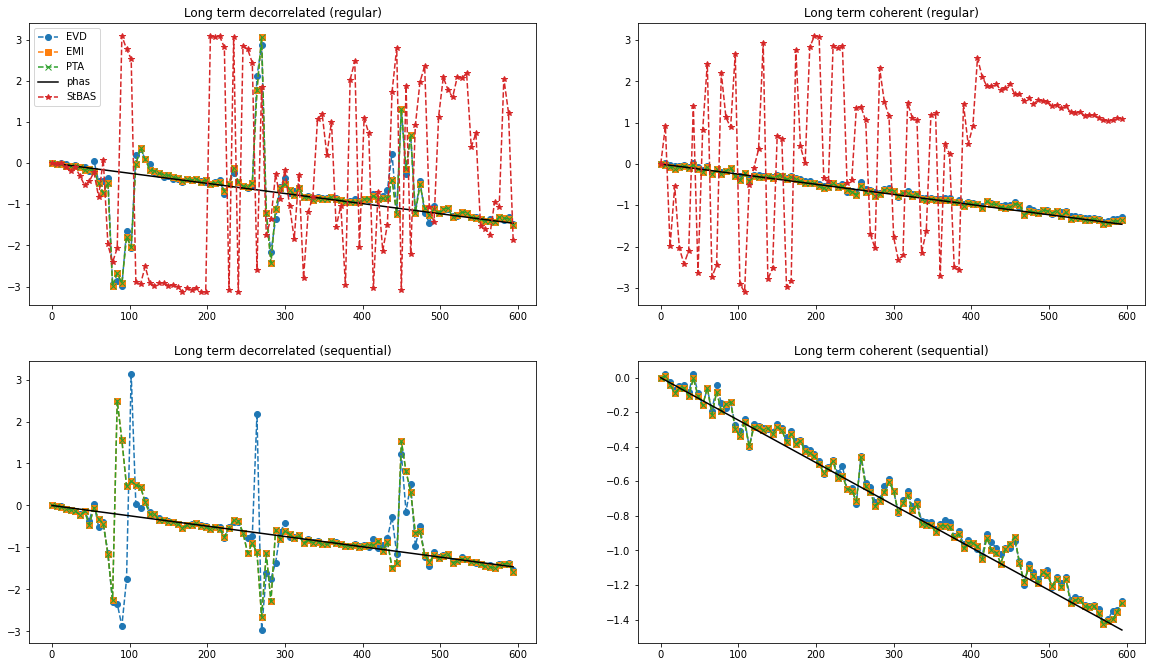

In [10]:
# running different methods for one realization (with seasonal decorrelation)

phas = -vel_phase * temp_baseline

ph_stbas, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm_s, 0, b'StBAS', False, 4)
ph_stbas_short = np.angle(np.array(ph_stbas)).reshape(-1, 1) 

ph_stbas, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm_s, 0, b'StBAS', False, 4)
ph_stbas_long = np.angle(np.array(ph_stbas)).reshape(-1, 1) 


####  Phase linking for long term decorrelated and long term coherent signal

### EVD
ph_EVD, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm_s, 0, b'EVD', False, 0)
ph_EVD_short = np.angle(np.array(ph_EVD)).reshape(-1, 1)
        
ph_EVD, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm_s, 0, b'EVD', False, 0)
ph_EVD_long = np.angle(np.array(ph_EVD)).reshape(-1, 1)


#### EMI
ph_EMI, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm_s, 0, b'EMI', False, 0)
ph_EMI_short = np.angle(np.array(ph_EMI)).reshape(-1, 1) 

ph_EMI, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm_s, 0, b'EMI', False, 0)
ph_EMI_long = np.angle(np.array(ph_EMI)).reshape(-1, 1) 

#### PTA
ph_PTA, noval, temp_quality = phase_linking_process_py(CCGsam_Sterm_s, 0, b'PTA', False, 0)
ph_PTA_short = np.angle(np.array(ph_PTA)).reshape(-1, 1) 

ph_PTA, noval, temp_quality = phase_linking_process_py(CCGsam_Lterm_s, 0, b'PTA', False, 0)
ph_PTA_long = np.angle(np.array(ph_PTA)).reshape(-1, 1) 

#### Sequential EVD

num_seq = np.int(n_img // 10)
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm_s, b'EVD', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EVD_short = np.angle(np.array(ph_vec)).reshape(-1, 1) 

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm_s, b'EVD', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EVD_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 

#### Sequential EMI
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm_s, b'EMI', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EMI_short = np.angle(np.array(ph_vec)).reshape(-1, 1) 

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm_s, b'EMI', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_EMI_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 


#### Sequential PTA
ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Sterm_s, b'PTA', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_PTA_short = np.angle(np.array(ph_vec)).reshape(-1, 1)

ph_vec, sqeezed, temp_quality = sequential_phase_linking_py(CCGsam_Lterm_s, b'PTA', 10, num_seq)
ph_vec = datum_connect_py(sqeezed, ph_vec, 10)
ph_vec_PTA_long = np.angle(np.array(ph_vec)).reshape(-1, 1) 




## plotting

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,11.4))

ax = axs[0,0]
ax.plot(temp_baseline, ph_EVD_short, 'o--')
ax.plot(temp_baseline, ph_EMI_short, 's--')
ax.plot(temp_baseline, ph_PTA_short, 'x--')
ax.plot(temp_baseline, phas,'k-')
ax.plot(temp_baseline, ph_stbas_short, '*--')
ax.legend(('EVD', 'EMI', 'PTA', 'phas', 'StBAS'))
ax.set_title('Long term decorrelated (regular)')

ax = axs[0,1]
ax.plot(temp_baseline, ph_EVD_long, 'o--')
ax.plot(temp_baseline, ph_EMI_long, 's--')
ax.plot(temp_baseline, ph_PTA_long, 'x--')
ax.plot(temp_baseline, phas,'k-')
ax.plot(temp_baseline, ph_stbas_long, '*--')
ax.set_title('Long term coherent (regular)')



ax = axs[1,0]
ax.plot(temp_baseline, ph_vec_EVD_short, 'o--')
ax.plot(temp_baseline, ph_vec_EMI_short, 's--')
ax.plot(temp_baseline, ph_vec_PTA_short, 'x--')
ax.plot(temp_baseline, phas,'k-')
ax.set_title('Long term decorrelated (sequential)')


ax = axs[1,1]
ax.plot(temp_baseline, ph_vec_EVD_long, 'o--')
ax.plot(temp_baseline, ph_vec_EMI_long, 's--')
ax.plot(temp_baseline, ph_vec_PTA_long, 'x--')
ax.plot(temp_baseline, phas,'k-')
ax.set_title('Long term coherent (sequential)')



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


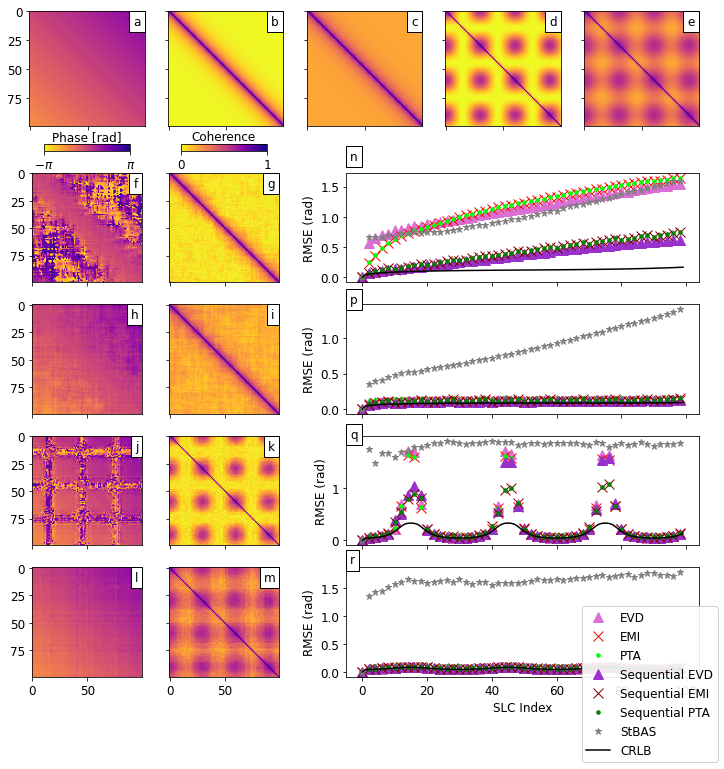

In [11]:
plt.rcParams["font.size"] = "12"
fig9 = plt.figure(figsize=(10, 10), constrained_layout=False)
gs1 = fig9.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.98, top=0.98, bottom=0.81,
                        hspace=0.2, wspace=0.2)
ax1 = fig9.add_subplot(gs1[0,0])
ax2 = fig9.add_subplot(gs1[0,1])
ax3 = fig9.add_subplot(gs1[0,2])
ax4 = fig9.add_subplot(gs1[0,3])
ax5 = fig9.add_subplot(gs1[0,4])


gs2 = fig9.add_gridspec(nrows=4, ncols=2, left=0.05, right=0.40, top=0.75, bottom=0.05,
                        hspace=0.2, wspace=0.2)

ax6 = fig9.add_subplot(gs2[0,0])
ax7 = fig9.add_subplot(gs2[0,1])
ax8 = fig9.add_subplot(gs2[1,0])
ax9 = fig9.add_subplot(gs2[1,1])
ax10 = fig9.add_subplot(gs2[2,0])
ax11 = fig9.add_subplot(gs2[2,1])
ax12 = fig9.add_subplot(gs2[3,0])
ax13 = fig9.add_subplot(gs2[3,1])

gs3 = fig9.add_gridspec(nrows=4, ncols=1, left=0.49, right=0.98, top=0.75, bottom=0.05,
                        hspace=0.2, wspace=0.2)

ax14 = fig9.add_subplot(gs3[0,0])
ax15 = fig9.add_subplot(gs3[1,0])
ax16 = fig9.add_subplot(gs3[2,0])
ax17 = fig9.add_subplot(gs3[3,0])


cmap, norm = custom_cmap(-np.pi,np.pi)
ax1.imshow(np.angle(coh_sim_S), cmap='plasma_r', norm=norm)
im1=ax6.imshow(np.angle(coh_est_S), cmap='plasma_r', norm=norm)
ax8.imshow(np.angle(coh_est_L), cmap='plasma_r', norm=norm)
ax10.imshow(np.angle(coh_est_S_s), cmap='plasma_r', norm=norm)
ax12.imshow(np.angle(coh_est_L_s), cmap='plasma_r', norm=norm)

cmap, norm = custom_cmap()
im2=ax2.imshow(np.abs(coh_sim_S), cmap='plasma_r', norm=norm)
ax3.imshow(np.abs(coh_sim_L), cmap='plasma_r', norm=norm)
ax4.imshow(np.abs(coh_sim_S_s), cmap='plasma_r', norm=norm)
ax5.imshow(np.abs(coh_sim_L_s), cmap='plasma_r', norm=norm)

ax7.imshow(np.abs(coh_est_S), cmap='plasma_r', norm=norm)
ax9.imshow(np.abs(coh_est_L), cmap='plasma_r', norm=norm)
ax11.imshow(np.abs(coh_est_S_s), cmap='plasma_r', norm=norm)
ax13.imshow(np.abs(coh_est_L_s), cmap='plasma_r', norm=norm)


rangelim = 6
colors = ['orchid','red','lime','darkorchid','maroon','green','gray']
linestyl = ['^','x','.','^','x','.', '*']
markersizzzz=['10','10','7','10','10','7', '7']
markersize=12


rmsemat_est = np.load('./simulation/rmsemat_modifiedSignalEq_linear.npy')

for t in range(rangelim):
    ax14.plot(np.ogrid[0:n_img:2],rmsemat_est[0::2,2*t],linestyl[t],color=colors[t], markersize=markersizzzz[t])
ax14.plot(np.ogrid[0:n_img:2],rmsemat_est[0::2,12], linestyl[6],color=colors[6], markersize=markersizzzz[6])
ax14.plot(crl_S,'k-', markersize=markersize)
ax14.set_ylabel('RMSE (rad)', fontsize=12)
for tick in ax14.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax14.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
ax14.set_xticklabels([])


for t in range(rangelim):
    ax15.plot(np.ogrid[0:n_img:2],rmsemat_est[0::2,2*t+1],linestyl[t],color=colors[t], markersize=markersizzzz[t])
ax15.plot(np.ogrid[0:n_img:2],rmsemat_est[0::2,13], linestyl[6],color=colors[6], markersize=markersizzzz[6])
ax15.plot(crl_L,'k-', markersize=markersize)
ax15.set_ylabel('RMSE (rad)', fontsize=12)
ax15.set_xticklabels([])


rmsemat_est = np.load('./simulation/rmsemat_modifiedSignalEq_linear_seasonal.npy')

for t in range(rangelim):
    ax16.plot(np.ogrid[0:n_img:2],rmsemat_est[0::2,2*t],linestyl[t],color=colors[t], markersize=markersizzzz[t])
ax16.plot(np.ogrid[0:n_img:2],rmsemat_est[0::2,12], linestyl[6],color=colors[6], markersize=markersizzzz[6])
ax16.plot(crl_S_s,'k-', markersize=markersize)
ax16.set_ylabel('RMSE (rad)', fontsize=12)
ax16.set_xticklabels([])



for t in range(rangelim):
    ax17.plot(np.ogrid[0:n_img:2],rmsemat_est[0::2,2*t+1],linestyl[t],color=colors[t], markersize=markersizzzz[t])
ax17.plot(np.ogrid[0:n_img:2],rmsemat_est[0::2,13], linestyl[6],color=colors[6], markersize=markersizzzz[6])
ax17.plot(crl_L_s,'k-', markersize=markersize)
ax17.set_xlabel('SLC Index', fontsize=12)
ax17.set_ylabel('RMSE (rad)', fontsize=12)

ax17.legend(('EVD','EMI','PTA','Sequential EVD','Sequential EMI','Sequential PTA', 'StBAS', 'CRLB'),
              loc='upper left', bbox_to_anchor=(0.65, 0.7), fontsize=12, framealpha=0.9)



plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)
plt.setp(ax7.get_xticklabels(), visible=False)
plt.setp(ax7.get_yticklabels(), visible=False)
plt.setp(ax8.get_xticklabels(), visible=False)
plt.setp(ax9.get_xticklabels(), visible=False)
plt.setp(ax9.get_yticklabels(), visible=False)
plt.setp(ax10.get_xticklabels(), visible=False)
plt.setp(ax11.get_xticklabels(), visible=False)
plt.setp(ax11.get_yticklabels(), visible=False)
plt.setp(ax13.get_yticklabels(), visible=False)



cax = fig9.add_axes([0.26, 0.78, 0.12, 0.01])
cbar = plt.colorbar(im2, cax=cax, ticks=[0,1], orientation='horizontal')
cbar.set_label('Coherence', fontsize=12,color = "black")
cbar.ax.set_xticklabels([r'0', r'1'], fontsize=12)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.xaxis.set_tick_params(color='black')
cbar.outline.set_edgecolor('black')
plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='black')

cax = fig9.add_axes([0.07, 0.78, 0.12, 0.01])
cbar = plt.colorbar(im1, cax=cax, ticks=[-np.pi, np.pi], orientation='horizontal')
cbar.set_label('Phase [rad]', fontsize=12,color = "black")
cbar.ax.set_xticklabels([r'$-\pi$',r'$\pi$'], fontsize=12)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.xaxis.set_tick_params(color='black')
cbar.outline.set_edgecolor('black')
plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='black')



ax1.text(92.5,9,'a', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax2.text(92,9,'b', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax3.text(93,9,'c', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax4.text(93,9,'d', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax5.text(92.5,9,'e', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax6.text(94,9,'f', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax7.text(92,9,'g', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax8.text(93,9,'h', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax9.text(94,9,'i', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax10.text(95,9,'j', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax11.text(93,9,'k', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax12.text(95,9,'l', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax13.text(91,9,'m', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax14.text(-2.5,2,'n', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax15.text(-2.5,1.54,'p', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax16.text(-2.5,2,'q', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax17.text(-3,2,'r', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))


plt.savefig('simulation/coh_matrix.eps', bbox_inches='tight', transparent=True)
plt.savefig('simulation/coh_matrix.png', bbox_inches='tight', transparent=True)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[1 2 3 4 5 6]


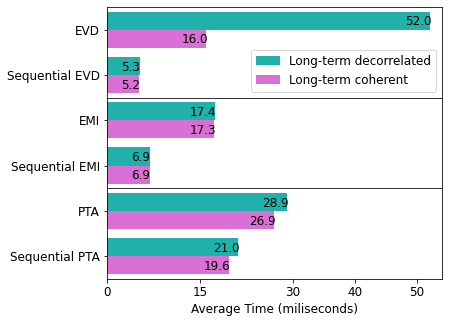

In [19]:
plt.rcParams["font.size"] = "12"

colors = ['lightseagreen','orchid','maroon','lime','green','darkorchid','red']
timesmat = np.load('./simulation/rmsemat_modifiedSignalEq_linear_time.npy')
timesmat = timesmat*1000

labels = ['Eigen-value decomposition (EVD)', 
          'Eigendecomposition based maximum-likelihood \nestimator of interferometric phase (EMI)',
          'Phase triangulation algorithm (PTA)', 
          'Sequential EVD',
          'Sequential EMI',
          'Sequential PTA']
labels = ['EVD', 
          'EMI',
          'PTA', 
          'Sequential EVD',
          'Sequential EMI',
          'Sequential PTA']


height = 0.4 
#fontsize=14
#,fontsize=fontsize
ind1 = np.arange(1, 7)
print(ind1)
ind = np.sort(np.array([ind1-height/2,ind1+height/2]).reshape(-1))

fig, ax = plt.subplots(3, 1, figsize=(6,5))

ax[0].barh(ind[0],timesmat[0],height=height,color=colors[0])
ax[0].barh(ind[1],timesmat[1],height=height,color=colors[1])
ax[0].barh(ind[2],timesmat[6],height=height,color=colors[0])
ax[0].barh(ind[3],timesmat[7],height=height,color=colors[1])
ax[0].set_ylim(0.5,2.5)
ax[0].set_xlim(0,54)

ax[0].set(xticklabels=[])
ax[0].set_yticks([1,2])
ax[0].set_yticklabels([labels[0],labels[3]])
ax[0].legend(('Long-term decorrelated','Long-term coherent'), loc='lower right')
ax[0].text(timesmat[0]-4, 0.9, str(round(timesmat[0],1)))
ax[0].text(timesmat[1]-4, 1.3, str(round(timesmat[1],1)))
ax[0].text(timesmat[6]-3, 1.9, str(round(timesmat[6],1)))
ax[0].text(timesmat[7]-3, 2.3, str(round(timesmat[7],1)))
ax[0].invert_yaxis()


ax[1].barh(ind[0],timesmat[2],height=height,color=colors[0])
ax[1].barh(ind[1],timesmat[3],height=height,color=colors[1])
ax[1].barh(ind[2],timesmat[8],height=height,color=colors[0])
ax[1].barh(ind[3],timesmat[9],height=height,color=colors[1])
ax[1].set_ylim(0.5,2.5)
ax[1].set_yticks([1,2])
ax[1].set(xticklabels=[])
ax[1].set_xlim(0,54)
ax[1].set_yticklabels([labels[1],labels[4]])
ax[1].text(timesmat[2]-4, 0.9, str(round(timesmat[2],1)))
ax[1].text(timesmat[3]-4, 1.3, str(round(timesmat[3],1)))
ax[1].text(timesmat[8]-3, 1.9, str(round(timesmat[8],1)))
ax[1].text(timesmat[9]-3, 2.3, str(round(timesmat[9],1)))
ax[1].invert_yaxis()


ax[2].barh(ind[0],timesmat[4],height=height,color=colors[0])
ax[2].barh(ind[1],timesmat[5],height=height,color=colors[1])
ax[2].barh(ind[2],timesmat[10],height=height,color=colors[0])
ax[2].barh(ind[3],timesmat[11],height=height,color=colors[1])
ax[2].set_ylim(0.5,2.5)
ax[2].set_yticks([1,2])
ax[2].set_xticks([0, 15, 30, 40, 50])
ax[2].set_xlim(0,54)
ax[2].set_yticklabels([labels[2],labels[5]])
ax[2].text(timesmat[4]-4, 0.9, str(round(timesmat[4],1)))
ax[2].text(timesmat[5]-4, 1.3, str(round(timesmat[5],1)))
ax[2].text(timesmat[10]-4, 1.9, str(round(timesmat[10],1)))
ax[2].text(timesmat[11]-4, 2.3, str(round(timesmat[11],1)))
ax[2].invert_yaxis()
ax[2].set_xlabel('Average Time (miliseconds)')

fig.subplots_adjust(hspace=0,wspace=0.1)
plt.savefig('simulation/timeplot.eps', bbox_inches='tight', transparent=True)
plt.savefig('simulation/timeplot.png', bbox_inches='tight', transparent=True)
plt.show()
